# Prediction of occurrence in spike in knee pain

## Model framework

- Starting data: 'Most important data' for participant 1
- Target: Identify days when the knee pain level increased by at least 2 in absolute value
- Prediction can be based on the activities on the day before the pain event only or also include the pain event day. We limit the reach in the past to avoid possible issues with overlapping pain events. 
- We can easily create different models using the variables:
    - pain = which pain to consider in the model
    - minpainchange = minimum change in pain that identifies a trigger event
    - otherpains =boolean that determines if we should use other pains as predictors for 'pain'
    - deniv = boolean that determines if we should consider mean denivelation. If True we drop data points where this parameter was not coorectly recorded
    - dayofpain =  boolean that determines if we should boolean that determines if we should consider the predictor collected the day of the pain event
    - startdate = earliest date to consider to avoid having initial pain drops 
    - bufferdays = number of days discarded after pain starts dropping - concerns the creation of the no-pain events
    - prepain = boolean that determines if we should consider pain events before the given event 
    - searchdays = number of days before the given event to check for pain events
    - fieldstodrop = 'types' of predictor to drop because irrelevant 
    - modeltype = whether to set up the model for a classification or a regression task

## Suggestions

- add pain in other regions in the previous day or both days as a predictor
- maybe add cumulative values for other predictors as well

## To do

- Change the way the pain events with a threshold distance are selected. I should do this after creating the pain event dates so that no pain events end up in the 'non-pain' dataframe

***
# Setup

### Imports

In [1]:
import pickle
from functools import wraps
from datetime import datetime

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc('axes',labelsize=25)
mpl.rc('xtick',labelsize=15)
mpl.rc('ytick',labelsize=15)
plt.rc('figure',figsize=(9,9))

import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 30)
pd.set_option("display.max_columns", 30)

### Functions

In [3]:
def dataf_size_log(func):
    '''
    Wrapper to functions that handle
    dataframes that return the df
    size after operation. 
    Helpful for troubleshooting.
    '''
    @wraps(func)
    def wrapper(dataf,*args,**kwargs):
        result = func(dataf,*args,**kwargs)
        print(f'{func.__name__} returns a {result.shape} dataframe')
        return result
    return wrapper


def load_data(datafolder,filename):
    '''
    Load preprocessed data
    
    Parameters
    ----------
    datafolder : string. 
        Folder where data is stored
    filename : string. 
        The name of the pickle file
    
    Returns
    -------
    data : pandas dataframe with most important data
    '''
    input = open(datafolder+filename, "rb")
    data = pickle.load(input)
    input.close()
    return data


@dataf_size_log
def start_pipeline(dataf):
    '''
    Placeholder function to 
    simply copy the original 
    dataframe at the beginning
    of a dataframe manipulation 
    pipeline.
    '''
    return dataf.copy()


@dataf_size_log
def set_column_type(dataf):
    '''
    Sets column names as lowercase 
    for ease of reference.
    Sets the type of the binary variables
    as integers also for ease of use.
    '''
    dataf = (dataf
             .rename(columns=str.lower)
             .assign(surfing=lambda x:x['surfing'].astype('int32'),
                     climbing=lambda x:x['climbing'].astype('int32'),
                     viaferrata=lambda x:x['viaferrata'].astype('int32'),
                     swimming=lambda x:x['swimming'].astype('int32'),
                     cycling=lambda x:x['cycling'].astype('int32')
                    )
            )
    return dataf
        

@dataf_size_log
def create_pain_change(dataf,pain):
    '''
    Add columns to dataframe 'dataf' containing information 
    on the percentage and overall change in pain between days
    
    Parameters:
    dataf : Pandas dataframe. 
        Input dataframe
    pain : string.
        Type of pain to be predicted. Can be one of
        ['kneepain','fingerhandarmpain', 'shoulderneckpain', 'foreheadeyespain']
        
    Returns: 
    dataf: modified dataframe
    '''
    dataf = (dataf
             .assign(pain_pct_change=lambda x:x[pain].pct_change(),
                     pain_change=lambda x:x[pain].diff()
                    )
            )
    return dataf
    
@dataf_size_log
def set_init_date(dataf,startdate):
    '''
    Select subsection of the dataframe starting from a date 
    that ensures that no pain drops are detected that do not 
    correspond to a visible pain spike. 
    
    Parameters:
    dataf: Pandas dataframe
        Input dataframe
    startdate: string. 
        Date to be used as starting point for analysis in the 
        format '%Y-%m-%d'
    
    Returns:
    dataf: Pandas dataframe
        Modified dataframe
    '''
    startdate = pd.to_datetime(startdate)
    dataf = dataf.loc[startdate:]
    return dataf

def find_event_indices(dataf,event='pain',minpainchange=1):
    '''
    Identifies the occurrences of spikes or drops in the 
    pain level (for the selected type of pain).
    
    Parameters
    ----------
    dataf: Pandas dataframe
        Input dataframe
    event: string.
        It can either be 'pain' to indentify the spikes in 
        pain level or 'nopain' (really any other string) to 
        identify the locations of the drops in pain
    minpainchange: int.
        Minimum pain change considered relevant to characterize
        a spike in pain. Currently for the drops in pain there
        is no threshold: as soon as the pain starts dropping we
        consider that the high pain status is over. 
        
    Returns
    -------
    eventidxs: Pandas dataframe
        Dataframe with date of events as Datetimeindex and 
        column containing information on the distance in days
        from the previous event. This column is not important
        and was just used to select only pain events that are 
        spaced by at least 2 days.
    '''
    paincheck = '>'+str(minpainchange) if event == 'pain' else '<0'
    lengthcheck = '>2' if event == 'pain' else '>0'
    eventidxs = (dataf
                 .query('pain_change'+paincheck)
                 .reset_index()
                 .loc[:,['index']]
                 .assign(date_range=lambda x:x['index']
                         .diff()
                         .dt.days
                        )
                 .set_index('index')
                 .query('date_range'+lengthcheck)
                )
    return eventidxs.sort_index()


def construct_pain_dates(eventidxs):
    
    paindates = eventidxs.index.union(eventidxs.index-pd.DateOffset(days=1)).unique()
    return paindates


def construct_nopain_dates(eventidxs,bufferdays,paindates):
    temp_dates=[]
    for idx in eventidxs.index:
        i=bufferdays
        test_array = []
        for j in range(bufferdays):
            test_array.append((idx+pd.DateOffset(days=j) not in paindates))
        checkforpain = all(test_array)
        while i>=bufferdays:
            daytoadd1 = idx+pd.DateOffset(days=i)
            daytoadd2 = daytoadd1+pd.DateOffset(days=1)
            if (daytoadd1 not in paindates) and (daytoadd2 not in paindates) and checkforpain:
                temp_dates.append(daytoadd1)
                temp_dates.append(daytoadd2)
                i += 2
            else:
                break
    nopaindates = pd.DatetimeIndex(set(temp_dates)).sort_values()
    return nopaindates


def create_pain_dataf(dataf,dates):
    dataf = (dataf
             .iloc[dataf.index.isin(dates)]
             .reset_index()
             .assign(event_num=lambda x:(x['index'].diff()>pd.Timedelta(days=1)).cumsum(),
                     counter = lambda x:1,
                     day_num = lambda x:x.groupby('event_num').agg({'counter':np.cumsum})
                    )
             .drop(['counter'],axis=1)
             .pivot(index='event_num',columns='day_num')
             .assign(pain=lambda x:1)
            )

    return dataf


def create_nopain_dataf(dataf,dates):
    dataf = (dataf
             .iloc[dataf.index.isin(dates)]
             .reset_index()
             .assign(event_num = lambda x:(x.index.values%2==0).cumsum(),
                     counter = lambda x:1,
                     day_num = lambda x:x.groupby('event_num').agg({'counter':np.cumsum})
                    )
             .drop(['counter'],axis=1)
             .pivot(index='event_num',columns='day_num')
             .assign(pain=lambda x:0)
            )
    return dataf


def find_previous_pain_events(dataf,painidxs,startdate,searchdays=30):
    prepain = []
    startdate = pd.to_datetime(startdate)
    for date in dataf['index_1']:
        if date - startdate < pd.Timedelta(days=searchdays):
            prepain.append(np.nan)
        else: 
            numpains = painidxs.loc[(date-pd.Timedelta(days=searchdays)):(date-pd.Timedelta(days=1))].shape[0]
            prepain.append(numpains)
    dataf.insert(loc=len(dataf.columns)-2,column='num_pain_events',value=pd.Series(prepain))
    return dataf    


@dataf_size_log
def create_event_dataf(dataf,bufferdays,startdate,searchdays,minpainchange):
    painidxs = find_event_indices(dataf,event='pain',minpainchange=1)
    paindates = construct_pain_dates(painidxs)
    paindataf = create_pain_dataf(dataf,paindates)
    
    nopainidx = find_event_indices(dataf,event='no_pain',minpainchange=1)
    nopaindates = construct_nopain_dates(nopainidx,bufferdays,paindates)
    nopaindataf = create_nopain_dataf(dataf,nopaindates)
    
    finaldataf = (pd.concat([paindataf,nopaindataf])
                  .reset_index()
                 )
    cols = [col for sublist in 
            np.array([['%s_%d' %(name,idx) for idx in range(2)] 
                      for name in dataf.reset_index().columns])
            for col in sublist]
    finaldataf.columns = ['event_num'] + cols + ['pain']
    finaldataf.pipe(find_previous_pain_events,
                    painidxs=painidxs,
                    startdate=startdate,
                    searchdays=searchdays)
    return finaldataf


@dataf_size_log
def keep_other_pains(dataf,pain,otherpains):
    if otherpains:
        pass
    else:
        ps = ['kneepain','fingerhandarmpain', 'shoulderneckpain', 'foreheadeyespain']
        pains_to_drop = [p for p in ps if p!=pain]
        dataf = (dataf
                 .drop(pains_to_drop,axis=1)
                )
    return dataf

@dataf_size_log
def keep_deniv_and_prepain(dataf,prepain,deniv,searchdays):
    if deniv:
        denivdates = dataf.query('tracker_mean_denivelation_0 == tracker_mean_denivelation_1')['index_1'].tolist()
        dataf = dataf.query('tracker_mean_denivelation_0 != tracker_mean_denivelation_1')
    else:
        dataf = dataf.drop(['tracker_mean_denivelation_0','tracker_mean_denivelation_1'],axis=1)
    if prepain:
        dataf = dataf.dropna()
        if deniv:
            dropdates = []
            for date in denivdates:
                for daystep in range(1,searchdays):
                    toappend = date+pd.Timedelta(days=daystep)
                    if toappend not in dropdates:
                        dropdates.append(toappend)
                    else:
                        pass
            dataf = dataf.query('index_1 not in @dropdates')
        else:
            pass
    else: 
        dataf.drop('num_pain_events',axis=1)
    return dataf

@dataf_size_log
def select_model_type(dataf,modeltype='classification'):
    if modeltype == 'classification':
        dataf = dataf.drop(['kneepain_0','kneepain_1'],axis=1)
    elif modeltype == 'regression':
        dataf = (dataf
                 .assign(pain_change=lambda x:x['kneepain_1']-x['kneepain_0'])
                 .drop(['kneepain_0','kneepain_1','pain'],axis=1)
                )
        dataf = dataf.drop('pain',axis)
    return dataf

@dataf_size_log
def use_day_of_pain(dataf,dayofpain):
    if not dayofpain:
        cols = [c for c in dataf.columns if c[-1]!='1']
        dataf = dataf[cols]
    return dataf

@dataf_size_log
def drop_unwanted_cols(dataf,fieldstodrop):
    colstodrop = []
    for field in fieldstodrop:
        for col in dataf.columns:
            if field in col:
                colstodrop.append(col)
    dataf = dataf.drop(colstodrop,axis=1)
    return dataf


def create_model_dataf(data,pain,otherpains,bufferdays,startdate,searchdays,deniv,dayofpain,prepain,modeltype,fieldstodrop):
    modeldf = (data
               .pipe(start_pipeline)
               .pipe(set_column_type)
               .pipe(create_pain_change,pain)
               .pipe(create_event_dataf,
                     bufferdays=bufferdays,
                     startdate=startdate,
                     searchdays=searchdays,
                     minpainchange=minpainchange
                    )
               .pipe(keep_other_pains,
                     pain=pain,
                     otherpains=otherpains)
               .pipe(keep_deniv_and_prepain,
                     deniv=deniv,
                     prepain=prepain,
                     searchdays=searchdays
                    )
               .pipe(select_model_type,
                     modeltype=modeltype
                    )
               .pipe(use_day_of_pain,
                     dayofpain=dayofpain
                    )
               .reset_index(drop=True)
               .pipe(drop_unwanted_cols,fieldstodrop)
              )
    return modeldf


def plot_feature_ranking(columns,boruta_rankings,green_ths,yellow_ths):
    fig,ax = plt.subplots(figsize=(10,8))
    
    plt.axvspan(0, green_ths, facecolor='g', alpha=0.6)
    plt.axvspan(green_ths, yellow_ths, facecolor='y', alpha=0.6)
    plt.axvspan(yellow_ths, max(boruta_rankings)+1, facecolor='r', alpha=0.6)
    
    y_pos = np.arange(len(columns))
    plt.barh(y_pos,boruta_rankings,alpha=0.8)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(columns)
    ax.set_xlabel('Rankings')
    ax.grid(False)
    
    plt.tight_layout()
    

### Data Import

In [804]:
datafolder = '../data/preprocessed/'
filename = 'preprocessedMostImportantDataParticipant1.txt'

In [970]:
data = load_data(datafolder,filename)

***
# Model 1 - Denivelation, pain occurring previously, other types of pain used as predictors

- We use denivelation (exclude datapoints where denivelation is not available)
- We include the attributes for the day when the pain event occurs
- We include the number of pain occurrences in the 15 days before a pain or non-pain event

### Variable definition

In [1036]:
pain = 'kneePain' # which pain to consider in the model
minpainchange = 2
otherpains = True # use other pains as predictors for 'pain'
deniv = True  # should we consider mean denivelation. If True we drop data points where this parameter was not coorectly recorded
dayofpain = True # should we consider the predictor collected the day of the pain event
startdate = '2016-01-11'  # earliest date to consider to avoid having initial pain drops 
bufferdays = 2  # number of days discarded after pain starts dropping - concerns the creation of the no-pain events
prepain = True
searchdays = 30 # number of days to check for pain events before a given pain or non-pain event
fieldstodrop = ['swimming', 'viaferrata','event_num','index',
                'pain_pct_change','pain_change','cycling','climbing',
                'surfing','sick',
               ]
modeltype = 'classification'

### Build dataframe

We create two columns that contain information on the change in the pain level for participant 1. One identifies the percentage of change and the other the absolute variation from the previous day.

In [1037]:
modeldf = create_model_dataf(data=data,
                             pain=pain,
                             otherpains=otherpains,
                             bufferdays=bufferdays,
                             startdate=startdate,
                             searchdays=searchdays,
                             deniv=deniv,
                             dayofpain=dayofpain,
                             prepain=prepain,
                             modeltype=modeltype,
                             fieldstodrop=fieldstodrop)

start_pipeline returns a (1825, 21) dataframe
set_column_type returns a (1825, 21) dataframe
create_pain_change returns a (1825, 23) dataframe
create_event_dataf returns a (475, 51) dataframe
keep_other_pains returns a (475, 51) dataframe
keep_deniv_and_prepain returns a (274, 51) dataframe
select_model_type returns a (274, 49) dataframe
use_day_of_pain returns a (274, 49) dataframe
drop_unwanted_cols returns a (274, 22) dataframe


### Quick exploration

In [1038]:
modeldf[modeldf['pain']==1]['num_pain_events'].mean()/modeldf[modeldf['pain']==0]['num_pain_events'].mean()

0.9544098001875906

In [1039]:
modeldf.corr()['pain'].sort_values(ascending=False)[1:]

scooterriding_0                0.202093
scooterriding_1                0.153609
tracker_mean_distance_1        0.131504
timedrivingcar_1               0.090173
tracker_mean_denivelation_1    0.082622
manictimedelta_corrected_0     0.037543
shoulderneckpain_0             0.010761
whatpulset_corrected_0         0.001950
shoulderneckpain_1            -0.003847
fingerhandarmpain_0           -0.007071
generalmood_1                 -0.045978
tracker_mean_distance_0       -0.067037
num_pain_events               -0.073905
tracker_mean_denivelation_0   -0.075353
generalmood_0                 -0.086605
foreheadeyespain_0            -0.092767
fingerhandarmpain_1           -0.096319
foreheadeyespain_1            -0.107383
timedrivingcar_0              -0.130789
manictimedelta_corrected_1    -0.180843
whatpulset_corrected_1        -0.209186
Name: pain, dtype: float64

### Sets preparation

In [1040]:
from sklearn.model_selection import train_test_split

In [1041]:
X = modeldf.drop('pain',axis=1)
y = modeldf['pain']

In [1042]:
X_train_val,X_test,y_train_val,y_test, = train_test_split(X,y,test_size=0.2,random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val,test_size=0.2,random_state=42)

### Random forest with all features

In [1043]:
from sklearn.model_selection import GridSearchCV

In [1044]:
rf_clf = RandomForestClassifier()

In [1045]:
param_grid = {
    'n_estimators':np.arange(150,250,10),
    'max_depth':np.arange(2,30,1)
}

In [1046]:
search = GridSearchCV(rf_clf,param_grid=param_grid,cv=5,n_jobs=-1,scoring='accuracy',return_train_score=True)

In [1047]:
search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'n_estimators': array([150, 160, 170, 180, 190, 200, 210, 220, 230, 240])},
             return_train_score=True, scoring='accuracy')

In [1048]:
search.best_estimator_

RandomForestClassifier(max_depth=16, n_estimators=200)

In [1049]:
search.best_score_

0.6685714285714285

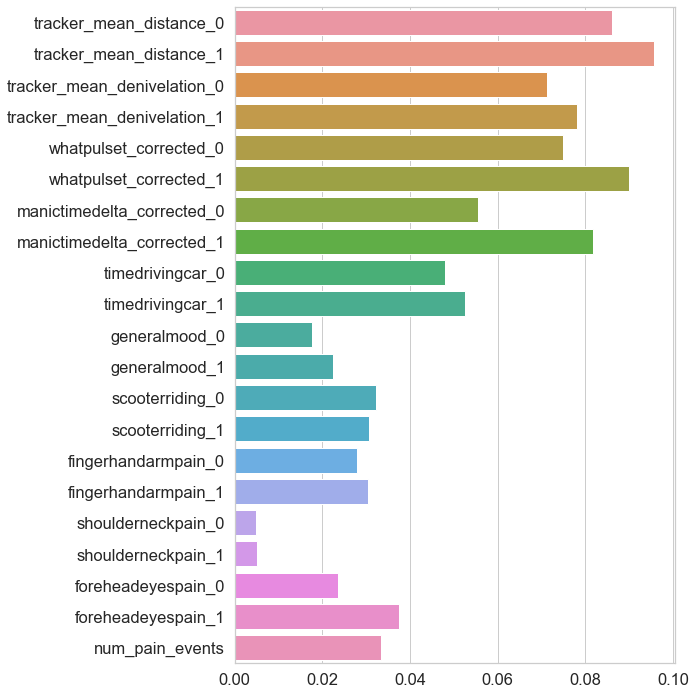

In [1050]:
fig,ax = plt.subplots(figsize=(10,10))
sns.barplot(y=X_train.columns,x=search.best_estimator_.feature_importances_,orient='horizontal')
plt.tight_layout()

In [1051]:
labels = ['No Pain','Pain']

In [1052]:
y_val_pred = search.predict(X_val)

In [1053]:
from sklearn.metrics import classification_report,confusion_matrix

In [1054]:
print(classification_report(y_val,y_val_pred,target_names=labels))

              precision    recall  f1-score   support

     No Pain       0.67      0.52      0.59        23
        Pain       0.58      0.71      0.64        21

    accuracy                           0.61        44
   macro avg       0.62      0.62      0.61        44
weighted avg       0.62      0.61      0.61        44



<AxesSubplot:>

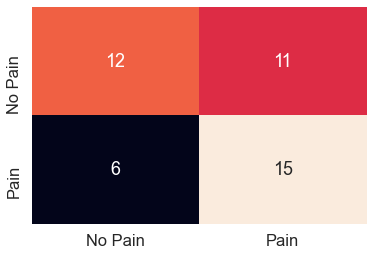

In [1055]:
fig,ax = plt.subplots(figsize=(6,4))
sns.heatmap(confusion_matrix(y_val,y_val_pred),annot=True, 
            xticklabels=labels, yticklabels=labels,
            cbar=False
           )

### Feature selection using Boruta

In [1056]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

In [1057]:
rf_clf = RandomForestClassifier(n_jobs=-1,max_depth=5)
boruta_selector = BorutaPy(rf_clf,
                           n_estimators='auto',
                           random_state=42
                          )
boruta_selector.fit(np.array(X_train),np.array(y_train))
boruta_ranking = boruta_selector.ranking_

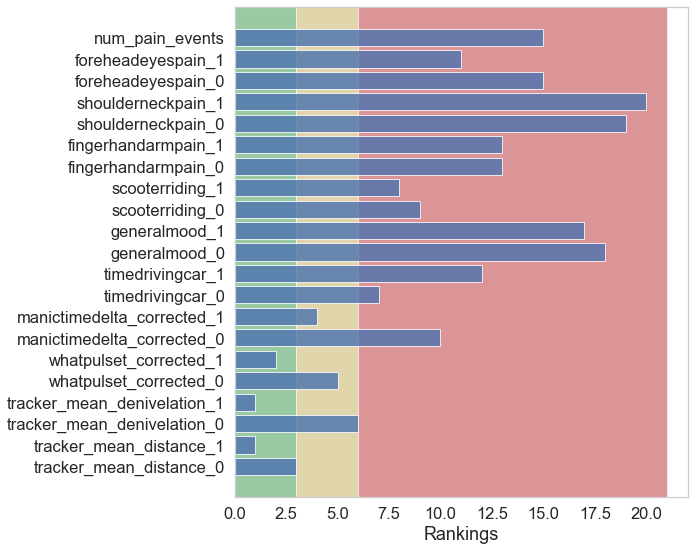

In [1058]:
plot_feature_ranking(X_train.columns,boruta_ranking,3,6)

In [1059]:
X_train.columns[boruta_selector.support_].tolist()

['tracker_mean_distance_1', 'tracker_mean_denivelation_1']

Only these two predictors seem to provide more information than noise for the prediction

In [1060]:
X_train_boruta = X_train[(X_train.columns[boruta_selector.support_].tolist()
                          +X_train.columns[boruta_selector.support_weak_].tolist())]
X_val_boruta = X_val[(X_val.columns[boruta_selector.support_].tolist()
                          +X_val.columns[boruta_selector.support_weak_].tolist())]
X_test_boruta = X_test[(X_test.columns[boruta_selector.support_].tolist()
                          +X_test.columns[boruta_selector.support_weak_].tolist())]

In [1061]:
rf_clf = RandomForestClassifier()

In [1062]:
param_grid = {
    'n_estimators':np.arange(100,500,50),
    'max_depth':np.arange(2,5,1)
}

In [1063]:
search = GridSearchCV(rf_clf,param_grid=param_grid,cv=5,n_jobs=-1,scoring='accuracy',return_train_score=True)

In [1064]:
search.fit(X_train_boruta,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([2, 3, 4]),
                         'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450])},
             return_train_score=True, scoring='accuracy')

In [1065]:
search.best_estimator_

RandomForestClassifier(max_depth=2, n_estimators=250)

In [1066]:
search.best_score_

0.6342857142857143

In [1067]:
labels = ['No Pain','Pain']

In [1068]:
y_val_pred = search.predict(X_val_boruta)

In [1069]:
from sklearn.metrics import classification_report,confusion_matrix

In [1070]:
print(classification_report(y_val,y_val_pred,target_names=labels))

              precision    recall  f1-score   support

     No Pain       0.50      0.43      0.47        23
        Pain       0.46      0.52      0.49        21

    accuracy                           0.48        44
   macro avg       0.48      0.48      0.48        44
weighted avg       0.48      0.48      0.48        44



<AxesSubplot:>

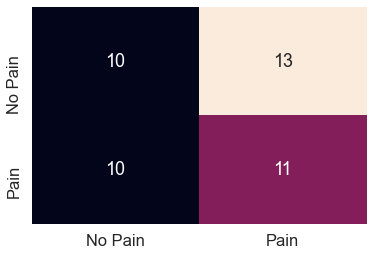

In [1071]:
fig,ax = plt.subplots(figsize=(6,4))
sns.heatmap(confusion_matrix(y_val,y_val_pred),annot=True, 
            xticklabels=labels, yticklabels=labels,
            cbar=False
           )

The results do seem to be worse though in this case

***
# Model 2 - No denivelation

- We do not use denivelation
- We include the attributes for the day when the pain event occurs
- We include the number of pain occurrences in the 15 days before a pain or non-pain event

### Variable definition

In [889]:
pain = 'kneePain' # which pain to consider in the model
minpainchange = 2
otherpains = True # use other pains as predictors for 'pain'
deniv = False  # should we consider mean denivelation. If True we drop data points where this parameter was not coorectly recorded
dayofpain = True # should we consider the predictor collected the day of the pain event
startdate = pd.to_datetime('2016-01-11')  # earliest date to consider to avoid having initial pain drops 
bufferdays = 2  # number of days discarded after pain starts dropping - concerns the creation of the no-pain events
prepain = True
searchdays = 10 # number of days to check for pain events before a given pain or non-pain event
fieldstodrop = ['swimming', 'viaferrata','event_num','index',
                'pain_pct_change','pain_change','cycling','climbing',
                'surfing','sick',
               ]
modeltype = 'classification'

### Build dataframe

We create two columns that contain information on the change in the pain level for participant 1. One identifies the percentage of change and the other the absolute variation from the previous day.

In [917]:
modeldf = create_model_dataf(data,pain,bufferdays,startdate,searchdays,deniv,dayofpain,prepain,cols_to_drop)

start_pipeline returns a (1825, 21) dataframe
set_column_type returns a (1825, 21) dataframe
select_pain returns a (1825, 18) dataframe
586
create_event_dataf returns a (475, 45) dataframe
apply_constraints returns a (469, 41) dataframe
drop_unwanted_cols returns a (469, 28) dataframe


### Quick exploration

In [891]:
modeldf.head()

,tracker_mean_distance_0,tracker_mean_distance_1,whatpulset_corrected_0,whatpulset_corrected_1,manictimedelta_corrected_0,manictimedelta_corrected_1,timedrivingcar_0,timedrivingcar_1,climbingdenivelation_0,climbingdenivelation_1,climbingmaxeffortintensity_0,climbingmaxeffortintensity_1,climbingmeaneffortintensity_0,climbingmeaneffortintensity_1,surfing_0,surfing_1,climbing_0,climbing_1,cycling_0,cycling_1,generalmood_0,generalmood_1,scooterriding_0,scooterriding_1,sick_tired_0,sick_tired_1,num_pain_events,pain
0,4.832535,5.211283,0.0,5546.0,0.0,262.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.771644,5.771644,0.0,0.0,1.0,1.0,0.0,1
1,4.401184,3.887420,7438.0,6306.0,373.0,184.0,20.0,80.0,0.0,23.0,0.0,5.8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.771644,5.771644,0.0,0.0,1.0,1.0,1.0,1
2,2.941429,3.995258,7812.0,4676.0,364.0,296.0,10.0,70.0,0.0,40.0,0.0,5.8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.771644,5.771644,0.0,0.0,1.0,1.0,2.0,1
3,2.511831,3.406096,13659.0,11748.0,498.0,516.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.771644,5.771644,0.0,0.0,1.0,1.0,2.0,1
4,4.011039,3.324560,14426.0,9805.0,484.0,446.0,50.0,5.0,0.0,45.0,0.0,5.6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.771644,5.771644,0.0,0.0,1.0,1.0,1.0,1


In [892]:
modeldf[modeldf['pain']==1]['num_pain_events'].mean()/modeldf[modeldf['pain']==0]['num_pain_events'].mean()

0.8853556485355649

In [893]:
modeldf.corr()['pain'].sort_values(ascending=False)[1:]

scooterriding_0                  0.167098
tracker_mean_distance_1          0.151678
scooterriding_1                  0.122836
timedrivingcar_1                 0.117450
surfing_0                        0.071853
cycling_0                        0.013989
climbingmeaneffortintensity_0   -0.002372
cycling_1                       -0.014467
surfing_1                       -0.021814
sick_tired_0                    -0.028733
tracker_mean_distance_0         -0.031225
climbingmaxeffortintensity_0    -0.032955
generalmood_0                   -0.036502
climbing_0                      -0.038559
climbingdenivelation_1          -0.041479
whatpulset_corrected_0          -0.043603
generalmood_1                   -0.050250
timedrivingcar_0                -0.068663
climbingmaxeffortintensity_1    -0.070675
manictimedelta_corrected_0      -0.071835
climbing_1                      -0.074196
sick_tired_1                    -0.074651
climbingdenivelation_0          -0.088430
climbingmeaneffortintensity_1   -0

### Sets preparation

In [894]:
from sklearn.model_selection import train_test_split

In [895]:
X = modeldf.drop('pain',axis=1)
y = modeldf['pain']

In [896]:
X_train_val,X_test,y_train_val,y_test, = train_test_split(X,y,test_size=0.2,random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val,test_size=0.2,random_state=42)

In [897]:
y_train.value_counts()

0    150
1    150
Name: pain, dtype: int64

### Feature selection using Boruta

In [898]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

In [899]:
rf_clf = RandomForestClassifier(n_jobs=-1,max_depth=5)
boruta_selector = BorutaPy(rf_clf,
                           n_estimators='auto',
                           random_state=42
                          )
boruta_selector.fit(np.array(X_train),np.array(y_train))
boruta_ranking = boruta_selector.ranking_

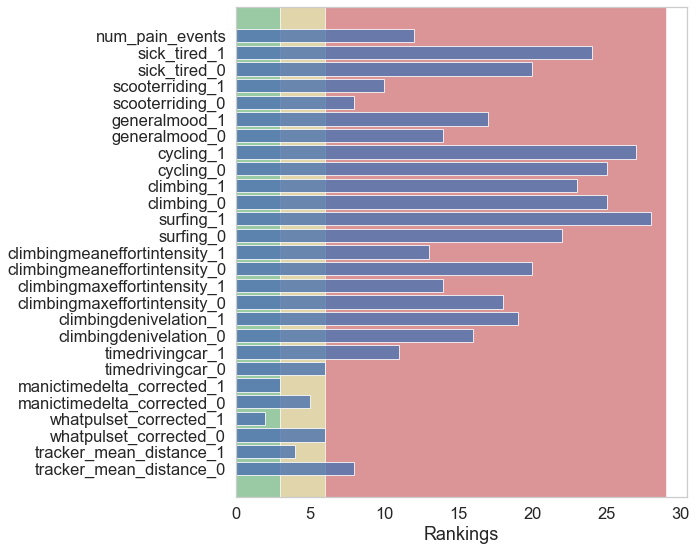

In [900]:
plot_feature_ranking(X_train.columns,boruta_ranking,3,6)

In [915]:
X_train.columns[boruta_selector.support_].to_list()

[]

In [916]:
X_train.columns[boruta_selector.support_weak_].to_list()

[]

### Random forest with all features

In [901]:
from sklearn.model_selection import GridSearchCV

In [902]:
rf_clf = RandomForestClassifier()

In [903]:
param_grid = {
    'n_estimators':np.arange(100,200,10),
    'max_depth':np.arange(2,30,1)
}

In [904]:
search = GridSearchCV(rf_clf,param_grid=param_grid,cv=5,n_jobs=-1,scoring='accuracy',return_train_score=True)

In [905]:
search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'n_estimators': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190])},
             return_train_score=True, scoring='accuracy')

In [906]:
search.best_estimator_

RandomForestClassifier(max_depth=2, n_estimators=120)

In [907]:
search.best_score_

0.5866666666666667

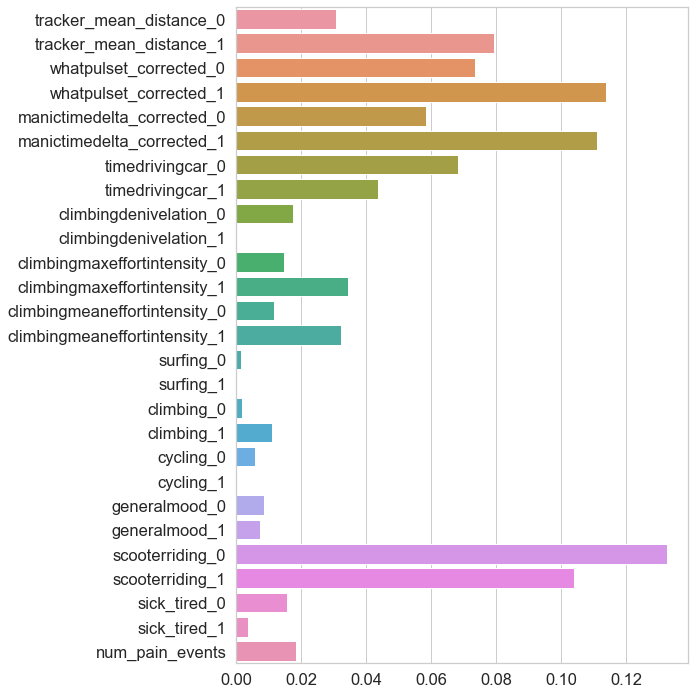

In [908]:
fig,ax = plt.subplots(figsize=(10,10))
sns.barplot(y=X_train.columns,x=search.best_estimator_.feature_importances_,orient='horizontal')
plt.tight_layout()

In [909]:
labels = ['No Pain','Pain']

In [910]:
y_val_pred = search.predict(X_val)

In [911]:
from sklearn.metrics import classification_report,confusion_matrix

In [912]:
print(classification_report(y_val,y_val_pred,target_names=labels))

              precision    recall  f1-score   support

     No Pain       0.64      0.64      0.64        36
        Pain       0.67      0.67      0.67        39

    accuracy                           0.65        75
   macro avg       0.65      0.65      0.65        75
weighted avg       0.65      0.65      0.65        75



<AxesSubplot:>

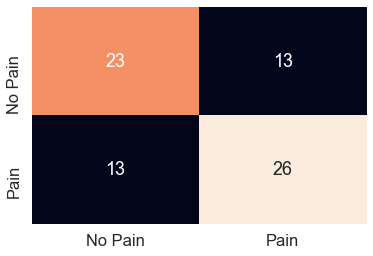

In [913]:
fig,ax = plt.subplots(figsize=(6,4))
sns.heatmap(confusion_matrix(y_val,y_val_pred),annot=True, 
            xticklabels=labels, yticklabels=labels,
            cbar=False
           )

***
# Model 3 - no info on day of pain

- We use denivelation
- We do not include the attributes for the day when the pain event occurs
- We include the number of pain occurrences in the 15 days before a pain or non-pain event

### Summary:

- It tends to guess that a pain event will emerge all the time

### Variable definition

In [2]:
pain = 'kneePain' # which pain to consider in the model
minpainchange = 2
otherpains = True # use other pains as predictors for 'pain'
deniv = True  # should we consider mean denivelation. If True we drop data points where this parameter was not coorectly recorded
dayofpain = False # should we consider the predictor collected the day of the pain event
startdate = '2016-01-11'  # earliest date to consider to avoid having initial pain drops 
bufferdays = 2  # number of days discarded after pain starts dropping - concerns the creation of the no-pain events
prepain = True
searchdays = 30 # number of days to check for pain events before a given pain or non-pain event
fieldstodrop = ['swimming', 'viaferrata','event_num','index',
                'pain_pct_change','pain_change','cycling','climbing',
                'surfing','sick',
               ]
modeltype = 'classification'

### Build dataframe

We create two columns that contain information on the change in the pain level for participant 1. One identifies the percentage of change and the other the absolute variation from the previous day.

In [861]:
modeldf = create_model_dataf(data,pain,bufferdays,startdate,searchdays,deniv,dayofpain,prepain,cols_to_drop)

start_pipeline returns a (1825, 21) dataframe
set_column_type returns a (1825, 21) dataframe
select_pain returns a (1825, 18) dataframe
586
create_event_dataf returns a (475, 45) dataframe
apply_constraints returns a (274, 23) dataframe
drop_unwanted_cols returns a (274, 16) dataframe


### Quick exploration

In [862]:
modeldf.head()

,tracker_mean_distance_0,tracker_mean_denivelation_0,whatpulset_corrected_0,manictimedelta_corrected_0,timedrivingcar_0,climbingdenivelation_0,climbingmaxeffortintensity_0,climbingmeaneffortintensity_0,surfing_0,climbing_0,cycling_0,generalmood_0,scooterriding_0,sick_tired_0,num_pain_events,pain
0,1.73,5.0,21991.0,552.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,5.771644,0.0,1.0,5.0,1
1,5.62,82.0,7034.0,169.0,40.0,60.0,5.8,0.0,0.0,1.0,0.0,5.771644,0.0,1.0,5.0,1
2,5.06,36.0,4479.0,163.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,6.000000,0.0,1.0,4.0,1
3,3.09,0.0,7814.0,231.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,7.000000,0.0,2.0,4.0,1
4,3.82,17.0,12859.0,346.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,7.000000,0.0,1.0,3.0,1


In [863]:
modeldf[modeldf['pain']==1]['num_pain_events'].mean()/modeldf[modeldf['pain']==0]['num_pain_events'].mean()

0.9544098001875906

In [864]:
modeldf.corr()['pain'].sort_values(ascending=False)[1:]

scooterriding_0                  0.202093
surfing_0                        0.157662
cycling_0                        0.063363
manictimedelta_corrected_0       0.037543
whatpulset_corrected_0           0.001950
sick_tired_0                     0.000284
climbingmaxeffortintensity_0    -0.021862
climbing_0                      -0.029854
climbingmeaneffortintensity_0   -0.032826
tracker_mean_distance_0         -0.067037
num_pain_events                 -0.073905
tracker_mean_denivelation_0     -0.075353
generalmood_0                   -0.086605
climbingdenivelation_0          -0.111548
timedrivingcar_0                -0.130789
Name: pain, dtype: float64

### Sets preparation

In [884]:
from sklearn.model_selection import train_test_split

In [885]:
X = modeldf.drop('pain',axis=1)
y = modeldf['pain']

In [886]:
X_train_val,X_test,y_train_val,y_test, = train_test_split(X,y,test_size=0.2,random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val,test_size=0.2,random_state=42)

In [888]:
y_train.value_counts()

1    100
0     75
Name: pain, dtype: int64

### Feature selection using Boruta

In [868]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

In [869]:
rf_clf = RandomForestClassifier(n_jobs=-1,max_depth=5)
boruta_selector = BorutaPy(rf_clf,
                           n_estimators='auto',
                           random_state=42
                          )
boruta_selector.fit(np.array(X_train),np.array(y_train))
boruta_ranking = boruta_selector.ranking_

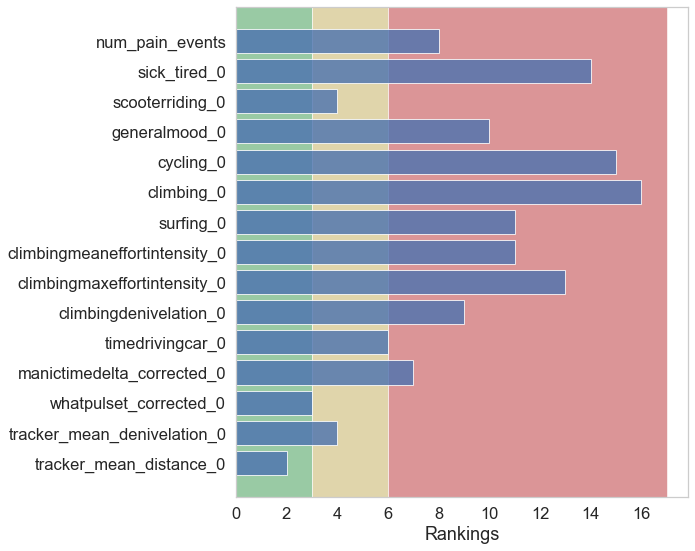

In [870]:
plot_feature_ranking(X_train.columns,boruta_ranking,3,6)

### Random forest with all features

In [848]:
from sklearn.model_selection import GridSearchCV

In [871]:
rf_clf = RandomForestClassifier()

In [872]:
param_grid = {
    'n_estimators':np.arange(100,200,10),
    'max_depth':np.arange(2,30,1)
}

In [873]:
search = GridSearchCV(rf_clf,param_grid=param_grid,cv=5,n_jobs=-1,scoring='accuracy',return_train_score=True)

In [874]:
search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'n_estimators': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190])},
             return_train_score=True, scoring='accuracy')

In [875]:
search.best_estimator_

RandomForestClassifier(max_depth=2, n_estimators=130)

In [876]:
search.best_score_

0.6114285714285714

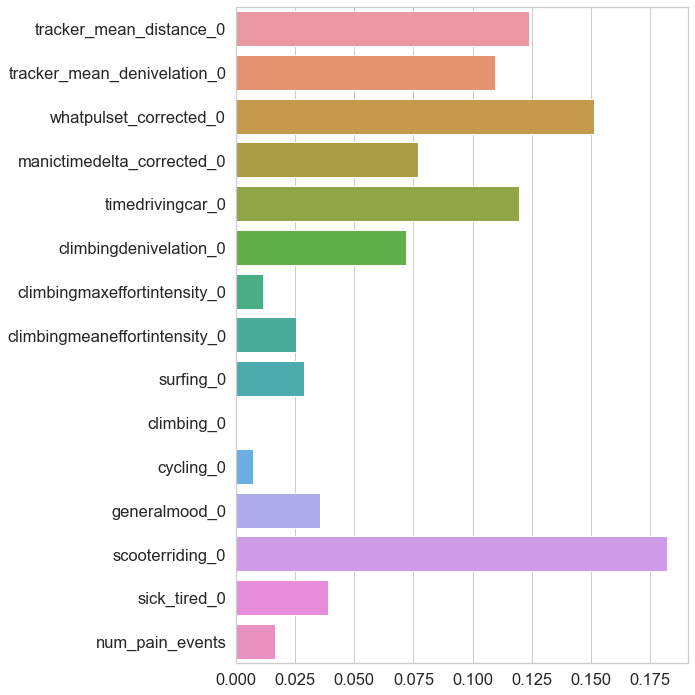

In [877]:
fig,ax = plt.subplots(figsize=(10,10))
sns.barplot(y=X_train.columns,x=search.best_estimator_.feature_importances_,orient='horizontal')
plt.tight_layout()

In [878]:
labels = ['No Pain','Pain']

In [879]:
y_val_pred = search.predict(X_val)

In [880]:
from sklearn.metrics import classification_report,confusion_matrix

In [881]:
print(classification_report(y_val,y_val_pred,target_names=labels))

              precision    recall  f1-score   support

     No Pain       0.33      0.04      0.08        23
        Pain       0.46      0.90      0.61        21

    accuracy                           0.45        44
   macro avg       0.40      0.47      0.34        44
weighted avg       0.40      0.45      0.33        44



<AxesSubplot:>

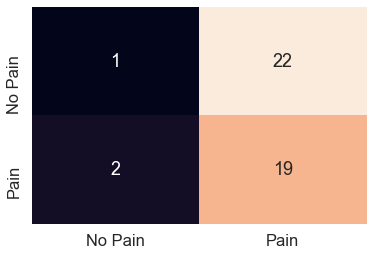

In [882]:
fig,ax = plt.subplots(figsize=(6,4))
sns.heatmap(confusion_matrix(y_val,y_val_pred),annot=True, 
            xticklabels=labels, yticklabels=labels,
            cbar=False
           )